# Fwumious Wabbit demo

 to learn more about Fwumious Wabbit go [here]( https://github.com/outbrain/fwumious_wabbit)

## part 1 - Wabbit showdown: Fwumious vs. Vowpal


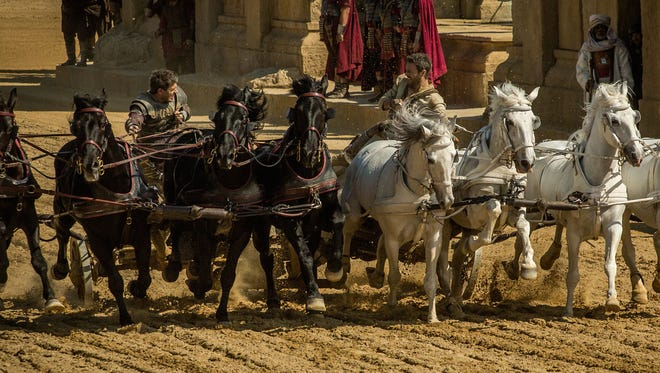

### the task: predict which animal likes to eat what



Our dataset will be a simple combination of animal and food and
outcome - either one likes it (1) or dislikes it (-1)

Namespace A will be Animal, and B will be Food. Each animal has its latent
type - Herbivore or Carnivore. And each food has its latent type - Plant or
Meat.

While we will name the features like Herbivore-13 and Plant-55, these are
just strings for the algo. But they are handy when we look at the data as
humans as the latent variable - and therefore the true value are clear to
us.

We will split each feature set into two - let's call them A1 & A2 set and B1
& B2 set.

Our training data will only have interactions between
- A1 and (B1 U B2)
- B1 and (A1 U A2)

Datasets created:
train.vw - In the training set there are no interactions between A2 and B2.
easy.vw - The distribution here is the same as in training dataset
hard.vw - The distribution here consists entirely of interactions between A2
and B2.

Notes:
- if we don't use feature combinations - only namespaces A and B in
isolation, then Logistic Regression will not be able to provide any
predictive power
- if we use plain feature combinations - AB, then LR will easily have
correct predictions on easy.vw, but not on hard.vw
- Only if the algo is able to capture the existence of latent variable will
it be able to perform beyond random on hard.vw

#### genereate dataset

In [12]:
!python generate.py

In [13]:
!rm *.fwcache

In [14]:
!rm *.cache

In [15]:
!time vw --data train.vw -l 0.1 -b 25 -c --adaptive --sgd --loss_function logistic --link logistic --power_t 0.0 --l2 0.0 --hash all --keep A --keep B

using namespaces beginning with: A B 
Num weight bits = 25
learning rate = 0.1
initial_t = 0
power_t = 0
creating cache_file = train.vw.cache
Reading datafile = train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.5000        3
0.680803 0.668460            2            2.0  -1.0000   0.4875        3
0.688027 0.695250            4            4.0  -1.0000   0.4763        3
0.654608 0.621189            8            8.0  -1.0000   0.4549        3
0.683323 0.712038           16           16.0   1.0000   0.4113        3
0.697248 0.711172           32           32.0   1.0000   0.5337        3
0.698934 0.700620           64           64.0  -1.0000   0.4747        3
0.695880 0.692827          128          128.0   1.0000   0.4660        3
0.703453 0.711026          256          256.0  -1.0000   0.2963        3
0.703492 0.

In [16]:
!time ./fw --data train.vw -l 0.1 -b 25 -c --adaptive --sgd --loss_function logistic --link logistic --power_t 0.0 --l2 0.0 --hash all --keep A --keep B

Num weight bits = 25
creating cache file = train.vw.fwcache
Elapsed: 1.23s rows: 5000000
./fw --data train.vw -l 0.1 -b 25 -c --adaptive --sgd --loss_function logisti  1.21s user 0.21s system 99% cpu 1.433 total
